# Projet_09 : Réalisez un traitement dans un environnement Big Data sur le Cloud

# Etape 1 : Préparez la chaîne de traitement PySpark en local
---

In [1]:
!pip freeze > requirements.txt

In [3]:
!conda env export > environment.yml

## Import des librairies

In [47]:
import pandas as pd
import PIL
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from typing import Iterator
import pyspark

import matplotlib.pyplot as plt
import matplotlib

import time
from contextlib import contextmanager

################################################################################
## Libraries version :

print(f"Pandas : {pd.__version__}")
print(f"Numpy : {np.__version__}")
print(f"Pillow : {PIL.__version__}")
print(f"Tensorflow : {tf.__version__}")
print(f"PySpark : {pyspark.__version__}")
print(f"Matplotlib : {matplotlib.__version__}")

Pandas : 2.2.3
Numpy : 1.26.4
Pillow : 11.1.0
Tensorflow : 2.18.0
PySpark : 3.5.4
Matplotlib : 3.9.2


In [14]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available: 1


Décorateur qui permet de mesurer le temps d'exécution d'une fonction :

In [17]:
@contextmanager
def timer(name):
    """Decorator that print the elapsed time and argument."""
    timing = {}
    t0 = time.time()
    yield timing
    timing["elapsed"] = time.time() - t0
    print(f"{name} - done in {timing['elapsed']:.0f}s")

Ajout d'une fonction de vidage de la mémoire du GPU :

In [18]:
from numba import cuda 

def clear_GPU_memory():
    device = cuda.get_current_device()
    device.reset()

---
## Définition des emplacements :

In [19]:
PATH = '/data/Formation_OC/Projet_09'
PATH_Data = PATH+'/data/Test/'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /data/Formation_OC/Projet_09
PATH_Data:   /data/Formation_OC/Projet_09/data/Test/
PATH_Result: /data/Formation_OC/Projet_09/data/Results


---
---
## 1.1 - Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P9**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

**Force Spark à utiliser l'env "projet_09" afin de trouver tensorflow !!**

In [21]:
# Spark uses global Tensorflow library. Need to help Spark to find the good version in the env
os.environ["PYSPARK_PYTHON"] = "/home/garth/anaconda3/envs/projet_09/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/garth/anaconda3/envs/projet_09/bin/python"

In [34]:
spark = (SparkSession
             .builder
             .appName('P9')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [23]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [24]:
spark

---
---
## 1.2 - Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.

In [25]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - les **labels** de chaque image

In [26]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------------------+----------+
|path                                                                |label     |
+--------------------------------------------------------------------+----------+
|file:/data/Formation_OC/Projet_09/data/Test/Watermelon/r_106_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/Test/Watermelon/r_109_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/Test/Watermelon/r_108_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/Test/Watermelon/r_107_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/Test/Watermelon/r_95_100.jpg |Watermelon|
+--------------------------------------------------------------------+----------+
only showing top 5 rows

None


---
---
## 1.3 - Préparation du modèle :

### 1.3.1 - Chargement du modèle : **MobileNetV2**

In [27]:
# load MobileNetV2 model 
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0


I0000 00:00:1738932254.333730   57828 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:10.0, compute capability: 8.6
2025-02-07 12:44:14.342903: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-02-07 12:44:14.342918: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.342921: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.526332: I tensorflow/core/common_runtime/placer.cc:162] x: (_DeviceArg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.526360: I tensorflow/core/common_runtime/placer.cc:162] Cast: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.526363: I tensorflow/core/common_runtim

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device

2025-02-07 12:44:14.953854: I tensorflow/core/common_runtime/placer.cc:162] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.953883: I tensorflow/core/common_runtime/placer.cc:162] Cast: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.953886: I tensorflow/core/common_runtime/placer.cc:162] y_RetVal: (_DeviceRetval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.956946: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.956965: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.956968: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:14.958812: I tensorflow/core/common_runtime/placer.cc:162] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-02-07 12:44:1

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

2025-02-07 12:44:15.156287: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.156303: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.158062: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.158081: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.159944: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.159960: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.165743: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

2025-02-07 12:44:15.359145: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.359160: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.360902: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.360917: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.362717: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.362732: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.364501: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

2025-02-07 12:44:15.561661: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.561675: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.563469: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.563484: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.565243: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.565257: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.567037: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:loca

2025-02-07 12:44:15.768035: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.768048: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.768702: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.768716: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.768720: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.770310: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.770325: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

2025-02-07 12:44:15.991274: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.991294: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.991299: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.993368: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.993383: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.993388: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:44:15.998546: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device

---
### 1.3.2 - Création de notre modèle sans la dernière couche :

In [28]:
# create our model without last layer
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [29]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workeurs.

In [30]:
brodcast_weights = sc.broadcast(new_model.get_weights())

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

2025-02-07 12:45:25.448278: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:45:25.448310: I tensorflow/core/common_runtime/placer.cc:162] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:45:25.448317: I tensorflow/core/common_runtime/placer.cc:162] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:45:25.449919: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:45:25.449943: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:45:25.449950: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-02-07 12:45:25.474408: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:G

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


<u>Mettons cela sous forme de fonction</u> :

In [43]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

---
---
## 1.4 - Featurisation :

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

### 1.4.1 - Fonctions :

In [48]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>')
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

---
### 1.4.2 - Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />

**Commande pour palier au problème de OOM :**  
*(A tester si besoin ou pas de garder cette commande dans le cloud)*

In [50]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [51]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [52]:
print(PATH_Result)

/data/Formation_OC/Projet_09/data/Results


**Vider la mémoire du GPU :**

In [53]:
clear_GPU_memory()

<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [54]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2025-02-07 12:59:53.531460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 12:59:53.539056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738933193.547995   60867 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738933193.550749   60867 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 12:59:53.560119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

---
### 1.4.3 - Vérification des résultats :

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [55]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [56]:
df.head()

,path,label,features
0,file:/data/Formation_OC/Projet_09/data/Test/Wa...,Watermelon,"[0.018639127, 0.09333114, 0.0, 0.0, 3.241871, ..."
1,file:/data/Formation_OC/Projet_09/data/Test/Wa...,Watermelon,"[0.0, 0.40663314, 0.02209134, 0.0, 1.5656763, ..."
2,file:/data/Formation_OC/Projet_09/data/Test/Pi...,Pineapple Mini,"[0.01529459, 4.683187, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,file:/data/Formation_OC/Projet_09/data/Test/Pi...,Pineapple Mini,"[0.0, 4.661444, 0.0, 0.0, 0.0, 0.0, 0.11449014..."
4,file:/data/Formation_OC/Projet_09/data/Test/Wa...,Watermelon,"[0.47469312, 0.4297937, 0.03198071, 0.01829032..."


In [57]:
df.shape

(22688, 3)

<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [58]:
df.loc[0,'features'].shape

(1280,)

---
---
## 1.5 - Réduction de dimension avec PCA :

Exemple PCA sur repo spark : [https://github.com/apache/spark/blob/master/examples/src/main/python/ml/pca_example.py](https://github.com/apache/spark/blob/master/examples/src/main/python/ml/pca_example.py)

In [59]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import Vectors, VectorUDT

---
### 1.5.1 - Création d'un dataframe Spark :

In [60]:
df_spark = spark.read.parquet(PATH_Result)

In [61]:
df_spark.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



---
### 1.5.2 - Transformation de "Floats" en vecteurs :

Afin de pouvoir réaliser une PCA sur la colonne "features" avec Spark, il faut la transformer en vecteur :

In [62]:
# array to dense vector
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

In [63]:
vector_df = df_spark.withColumn("features_vec", to_vector_udf(col("features")))

In [64]:
vector_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



---
### 1.5.3 - PCA - Recherche du nombre de Composantes Principales :

Recherche du nombre de composantes principales pour une variance expliquée de :
* 80%
* 90%

In [65]:
pca = PCA(k=200, inputCol="features_vec", outputCol="pca_features")
pca_model = pca.fit(vector_df)

25/02/07 13:04:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [66]:
# explained variance
explained_variance = pca_model.explainedVariance.toArray()

# cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# find k for 80% of variance
k_optimal_80 = np.argmax(cumulative_variance >= 0.80) +1
# find k for 90% of variance
k_optimal_90 = np.argmax(cumulative_variance >= 0.90) +1

print(f"Quantity of principal components for 80% of variance : {k_optimal_80}")
print(f"Quantity of principal components for 90% of variance : {k_optimal_90}")

Quantity of principal components for 80% of variance : 80
Quantity of principal components for 90% of variance : 186


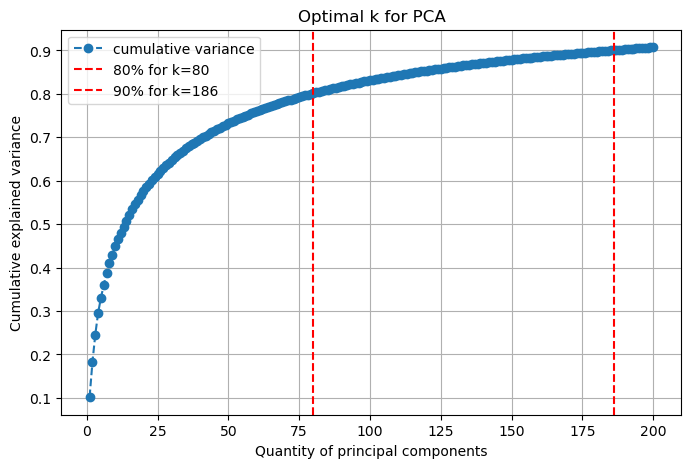

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), 
         cumulative_variance, 
         marker='o', 
         linestyle='--', 
         label="cumulative variance"
        )
plt.axvline(x=k_optimal_80, color='r', 
            linestyle='--', 
            label=f"80% for k={k_optimal_80}"
           )
plt.axvline(x=k_optimal_90, color='r', 
            linestyle='--', 
            label=f"90% for k={k_optimal_90}"
           )

plt.xlabel("Quantity of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Optimal k for PCA")
plt.legend()
plt.grid()

plt.show()

---
### 1.5.4 - Application de la PCA avec k optimal :

In [68]:
clear_GPU_memory()

In [69]:
with timer("PCA process for CumVar = 80%") as t:
    pca_final_80 = PCA(k=k_optimal_80, inputCol="features_vec", outputCol="pca_features")
    pca_model_final_80 = pca_final_80.fit(vector_df)

    df_pca_80 = pca_model_final_80.transform(vector_df)

PCA process for CumVar = 80% - done in 17s


In [70]:
clear_GPU_memory()

In [71]:
with timer("PCA process for CumVar= 90%") as t:
    pca_final_90 = PCA(k=k_optimal_90, inputCol="features_vec", outputCol="pca_features")
    pca_model_final_90 = pca_final_90.fit(vector_df)

    df_pca_90 = pca_model_final_90.transform(vector_df)

PCA process for CumVar= 90% - done in 17s


**Commentaires :**  
Le temps de calcul de la réduction de dimension à 80% de variance expliquée est équivalent à 90%.  
Je garde la réduction de dimension à 90% de variance expliquée avec 186 Composantes Principales.

In [72]:
type(df_pca_90)

pyspark.sql.dataframe.DataFrame

In [73]:
df_pca_90

DataFrame[path: string, label: string, features: array<float>, features_vec: vector, pca_features: vector]

In [74]:
df_pca_90.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [75]:
df_pca_90.select("pca_features").first()["pca_features"].size

25/02/07 13:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1904.0 KiB


186

---
---
## 1.6 - Création d'un Pipeline :

Afin de gagner en efficacité, j'intègre tout le processus dans un pipeline :  
**featurisation** + **vectorisation** + **PCA**

In [76]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

Utilisation de `VectorAssembler` pour la vestorisation en production, plus efficace en pipeline.

In [77]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



Idem précédemment, il faut convertir la colonne "features" en Vecteur Dense.

In [78]:
# array to dense vector
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

In [79]:
features_df = features_df.withColumn("features_vec", to_vector_udf(col("features")))

In [80]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



In [81]:
# convert "features" array in vector
vector_assembler = VectorAssembler(inputCols=["features_vec"], outputCol="features_vec_final")

In [82]:
# PCA
k_optimal = 186
pca = PCA(k=k_optimal, inputCol="features_vec_final", outputCol="pca_features")

In [83]:
# pipeline
pipeline = Pipeline(stages=[vector_assembler, pca])

**Test du pipeline :**

In [84]:
# fit 
pipeline_model = pipeline.fit(features_df)

2025-02-07 14:00:56.459788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 14:00:56.467715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738936856.476972   98354 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738936856.479748   98354 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 14:00:56.489033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [85]:
# transform
df_pca = pipeline_model.transform(features_df)

2025-02-07 14:09:17.920648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 14:09:17.929153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738937357.940192  104128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738937357.943058  104128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 14:09:17.953140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [86]:
df_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)
 |-- features_vec_final: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [87]:
df_pca.show(5)

25/02/07 14:09:29 WARN DAGScheduler: Broadcasting large task binary with size 1922.5 KiB
2025-02-07 14:09:29.952131: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 14:09:29.960704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738937369.971130  104304 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738937369.974131  104304 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 14:09:29.984377: I tensorflow/core/platform

+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|                path|         label|            features|        features_vec|  features_vec_final|        pca_features|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|file:/data/Format...|    Watermelon|[0.018639127, 0.0...|[0.01863912679255...|(1280,[0,1,4,5,6,...|[0.75155697228773...|
|file:/data/Format...|    Watermelon|[0.0, 0.40663314,...|[0.0,0.4066331386...|[0.0,0.4066331386...|[-2.1984573517368...|
|file:/data/Format...|Pineapple Mini|[0.01529459, 4.68...|[0.01529459003359...|(1280,[0,1,6,9,12...|[-5.4615838167441...|
|file:/data/Format...|Pineapple Mini|[0.0, 4.661444, 0...|[0.0,4.6614441871...|(1280,[1,6,7,14,1...|[-4.2276417182354...|
|file:/data/Format...|    Watermelon|[0.47469312, 0.42...|[0.47469311952590...|[0.47469311952590...|[-2.3021281461487...|
+--------------------+--

Enregistrement en fichiers "parquet" :

In [88]:
df_pca.write.mode("overwrite").parquet(PATH_Result)

25/02/07 14:09:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
2025-02-07 14:09:45.797842: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 14:09:45.805861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738937385.815777  104552 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738937385.818583  104552 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 14:09:45.828378: I tensorflow/core/platform/cp

Possibilité de sauvegarder le pipeline et de le recharger ensuite :

In [90]:
# save pipeline
pipeline_model.save("../model/model_pca")

25/02/07 14:12:24 WARN TaskSetManager: Stage 51 contains a task of very large size (1908 KiB). The maximum recommended task size is 1000 KiB.


Recharge avec :

In [ ]:
from pyspark.ml import PipelineModel
pipeline_model_loaded = PipelineModel.load("../model/model_pca")